# **Segundo conjunto de tareas a realizar**

## Paquetes necesarios e inicializaciones

Para la realización de las siguientes tareas, se va a utilizar el mismo *enviroment* de Python llamado VC_P1 creado en el [primer conjunto de tareas](../VC_P1/Exercises_P1.ipynb), la única dependencia adicional que se ha de descargar es la que viene dada por el paquete **Pillow**.

In [ ]:
pip install Pillow

Adicionalmente, se va a cargar la [imagen](../VC_P2/Resources/mandril.jpg) a utilizar en las posteriores tareas, de forma que no sea necesario cargarla en cada uno de los ejercicios en donde se requiera su uso.

Adicionalmente, se van a inicializar todos los paquetes requeridos para la correcta ejecución de los ejercicios.

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

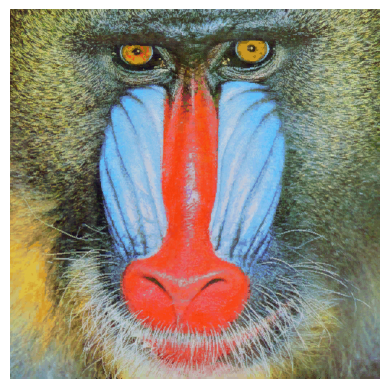

La imagen tiene un tamaño de 512x512 pixeles


In [6]:
#Lee imagen de archivo
image = cv2.imread('Resources/mandril.jpg') 

if image is not None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis("off")
    plt.imshow(image_rgb) 
    plt.show()
    heigth, width = image.shape[:2]
    print(f'La imagen tiene un tamaño de {width}x{heigth} pixeles')
else: 
    print('Imagen no encontrada')

## Número máximo de píxeles blancos

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

## Umbralizado de imagen a 8 bits

TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

## Modos de captura por WebCam

TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.

## ¿?

TAREA: Tras ver los vídeos My little piece of privacy, Messa di voce y Virtual air guitar proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.